In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import warnings
import chainladder as cl # Sparse=0.14.0 ; incremental.py np.NINF -> -np.inf
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [139]:
def claims_formatter(doc:pd.DataFrame):
    doc_copy = doc.copy()
    
    #Acomodo indice
    doc_copy.index = doc_copy.AUTOMOTORES
    formatted_doc = doc_copy.iloc[:,4:].stack(level = [0,1,2,3]).reset_index([1,2,3,4]).drop_duplicates()
    formatted_doc.reset_index(inplace = True)
    formatted_doc[['Base Origen', 'Ramo', 'Codigo 1', 'Codigo 2']] = pd.DataFrame(formatted_doc[('index','')].to_list(), index = formatted_doc.index)

    #Acomodo columnas
    formatted_doc.columns = ['indice','Tipo', 'Periodo', 'Desarrollo 1', 'Año Valuacion', 'Pendientes', 'Pagados', 'Incurridos', 'Cantidad', 'Base Origen', 'Ramo', 'Codigo 1', 'Codigo 2']
    formatted_doc['Año Ocurrencia'] = pd.to_datetime(formatted_doc['Periodo'][0][0:5]) + pd.DateOffset(months = 6)
    formatted_doc['Año Valuacion'] = pd.to_datetime(formatted_doc['Año Valuacion'])
    #formatted_doc['Desarrollo'] = formatted_doc['Año Valuacion'] - formatted_doc['Año Ocurrencia']
    formatted_doc.drop(['indice','Tipo', 'Periodo', 'Desarrollo 1'], axis = 1, inplace = True)

    return formatted_doc

def check_chainladder_assumptions( triangle:cl.Triangle, columns:list):
    for column in columns:
        if triangle[column].sum().valuation_correlation(p_critical=0.1, total=True).z_critical.values == True:
            print(f'Triangulo {column}: Años de valuación correlacionados')
        elif triangle[column].sum().development_correlation(p_critical=0.1).t_critical.values == False:
            print(f'Triangulo {column}: Años de desarrollo no correlacionados')
    return 0


def rgaa_chainladder(triang_stos_act:cl.Triangle):

    #Valores Actuales
    latest_diag = triang_stos_act['Incurridos'].incr_to_cum().latest_diagonal.to_frame()  

    #Modelo CL
    pipe_rgaa = cl.Pipeline(steps=[
        ("development", cl.Development(average="volume")),
        ("tail", cl.TailConstant(tail=1.05, decay = 1)),
        ('cl_model', cl.Chainladder() ),    
    ])

    triang_rgaa = pipe_rgaa.fit(triang_stos_act['Incurridos'].incr_to_cum())

    #CDFs & Ultimate
    cl_triang = triang_rgaa.named_steps.cl_model.full_triangle_.to_frame()
    cl_cdfs = triang_rgaa.named_steps.cl_model.cdf_.to_frame().melt()

    cl_ultimate = cl_triang.iloc[:,len(cl_triang.columns)-1]
    cl_cdfs = cl_cdfs[len(cl_cdfs)-2::-1].set_index(latest_diag.index, drop = True )

    #Concateno todo
    result = pd.concat([latest_diag, cl_cdfs['value'], cl_ultimate], axis = 1)
    result.columns = ['Actual', 'FDA', 'Ultimate']
    result['IBNR'] = result['Ultimate'] - result['Actual']

    return result
            

In [114]:
sto_input = pd.read_excel('..\\sample\\ssn_20232024_desarrollo_siniestros_automotores.xlsx', sheet_name = None, header=[0,1,2,3,4,5])
facpce_input = pd.read_excel('..\\sample\\Indice-FACPCE-Res.-JG-539-18-_2025-07-1.xlsx', skiprows = 2, skipfooter=4)

#Tratamiendo desarrollo de stos
#sto_input = dict(itertools.islice(sto_input.items(), 3, len(sto_input)))
sto_input_formateado = [claims_formatter(sto_input[k]) for k in sto_input.keys() if (k[0] == '2') or (k[0] == '1')]
db_stos = pd.concat(sto_input_formateado)

#Tratamiento indice facpce
db_facpce = facpce_input.set_index('MES')
factores_facpce = db_facpce.loc[max(db_stos['Año Valuacion']) - pd.DateOffset(days = 29)] / db_facpce.loc[db_stos['Año Valuacion'] - pd.DateOffset(months = 5, days = 29)] # Asumo que esta todo valuado a mitad de periodo.
db_stos['Factor FACPSE'] = factores_facpce.set_index(db_stos.index)

#Armo el dataframe para el triángulo que quiero analizar 
idx = (db_stos['Base Origen'] == '[HG]') & (db_stos['Ramo'].str.contains('RC ', na=False))
db_triangle = db_stos.loc[idx, ['Año Ocurrencia', 'Año Valuacion', 'Pendientes','Pagados' , 'Incurridos', 'Factor FACPSE', 'Cantidad', 'Ramo']]
db_triangle['Año Valuacion'] = db_triangle['Año Valuacion'] + pd.DateOffset(months = -6)
db_triangle['Año Ocurrencia'] = db_triangle['Año Ocurrencia'] + pd.DateOffset(months = -6)

#Chequeo supuestos para Cl y aplico el factor FACPCE
triang_stos = cl.Triangle(db_triangle, origin = 'Año Ocurrencia', development= 'Año Valuacion', columns = ['Pagados', 'Pendientes', 'Incurridos', 'Cantidad'], index=['Ramo'], cumulative = True)
triang_facpce = cl.Triangle(db_triangle, origin = 'Año Ocurrencia', development= 'Año Valuacion', columns = 'Factor FACPSE', index = ['Ramo'])
triang_stos_act = triang_stos.cum_to_incr() * triang_facpce
#check_chainladder_assumptions(triang_stos_act, ['Pagados', 'Pendientes', 'Incurridos'])

In [ ]:
#RGAA
pipe_rgaa = cl.Pipeline(steps=[
    ("development", cl.Development(average="volume")),
    ("tail", cl.TailConstant(tail=1.05, decay = 1)),
    ('model', cl.Chainladder() )])

triang_rgaa = pipe_rgaa.fit(triang_stos_act['Incurridos'].incr_to_cum())

In [148]:
triang_stos_act['Incurridos']

,Triangle Summary
Valuation:,2023-12
Grain:,OYDY
Shape:,"(3, 1, 6, 6)"
Index:,[Ramo]
Columns:,[Incurridos]


In [124]:
rgaa_ibnr = triang_rgaa.named_steps.model.ibnr_.to_frame()

In [128]:
triang_rgaa.named_steps.model.ibnr_

,Triangle Summary
Valuation:,2261-12
Grain:,OYDY
Shape:,"(3, 1, 6, 1)"
Index:,[Ramo]
Columns:,[Incurridos]


In [144]:
rgaa_ibnr.T.sum()

Ramo
RC daños a cosas                   5.385707e+11
RC lesiones 3º no transportados    1.053051e+12
RC lesiones 3º transportados       6.775297e+10
dtype: float64

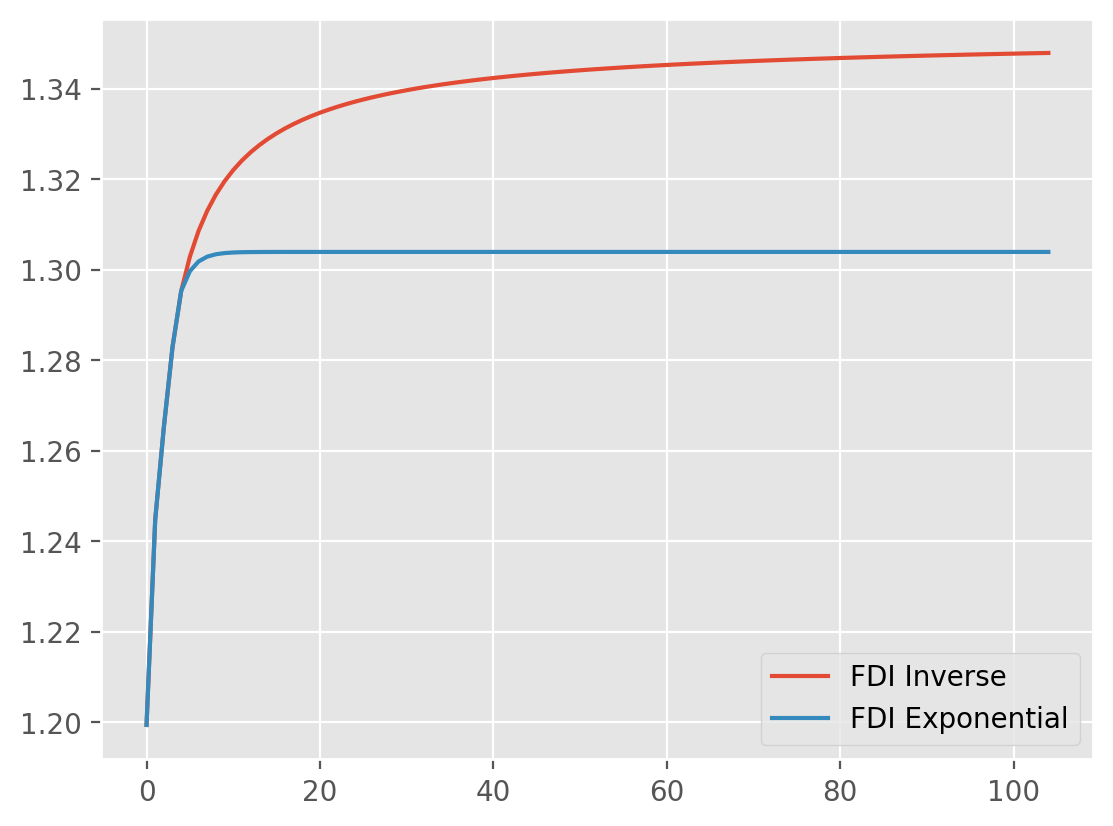

In [ ]:
#Analisis de Extrapolación de cola

ramos = ['RC daños a cosas', 'RC lesiones 3º no transportados',
       'RC lesiones 3º transportados']
ramo = ramos[0]


tria = triang_stos_act[triang_stos_act['Ramo']==ramo]['Incurridos'].incr_to_cum()

dev = cl.Development().fit_transform(tria)
tail_inv = cl.TailCurve(curve='inverse_power').fit(dev)
tail_exp = cl.TailCurve(curve='exponential').fit(dev)
values_list = tail_inv.ldf_['Incurridos'].to_frame().values.flatten().tolist()

inv_power_tail = 1 + np.exp(tail_inv.intercept_.values) * (
        np.arange(
            tria.shape[-1], 
            tria.shape[-1] + tail_inv.extrap_periods
        ) ** tail_inv.slope_.values)

exp_power_tail = 1+np.exp(
        np.arange(tria.shape[-1],
                  tria.shape[-1] + tail_exp.extrap_periods) * 
        tail_exp.slope_.values + tail_exp.intercept_.values)

fdi_inv = values_list[:-2] + inv_power_tail.tolist()[0]
fdi_exp = values_list[:-2] + exp_power_tail.tolist()[0]

# Flatten the lists to ensure they are one-dimensional
fdi_inv_flat = np.cumprod(fdi_inv)
fdi_exp_flat = np.cumprod(fdi_exp)

# Plot the flattened arrays
plt.plot(fdi_inv_flat, label='FDI Inverse')
plt.plot(fdi_exp_flat, label='FDI Exponential')
plt.legend()
plt.show()

In [195]:
#IFRS 17
#C-L

pipe = cl.Pipeline(
    steps=[
    ('dev', cl.Development(average='volume')),
    ('tail', cl.TailCurve('inverse_power', extrap_periods= 16, projection_period=16*12)),
    ('model', cl.Chainladder())])

pipe.fit(triang_stos_act['Incurridos'].incr_to_cum())

,steps,"[('dev', ...), ('tail', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,n_periods,-1
,average,'volume'
,sigma_interpolation,'log-linear'
,drop,None
,drop_high,None
,drop_low,None
,preserve,1


<Axes: xlabel='development'>

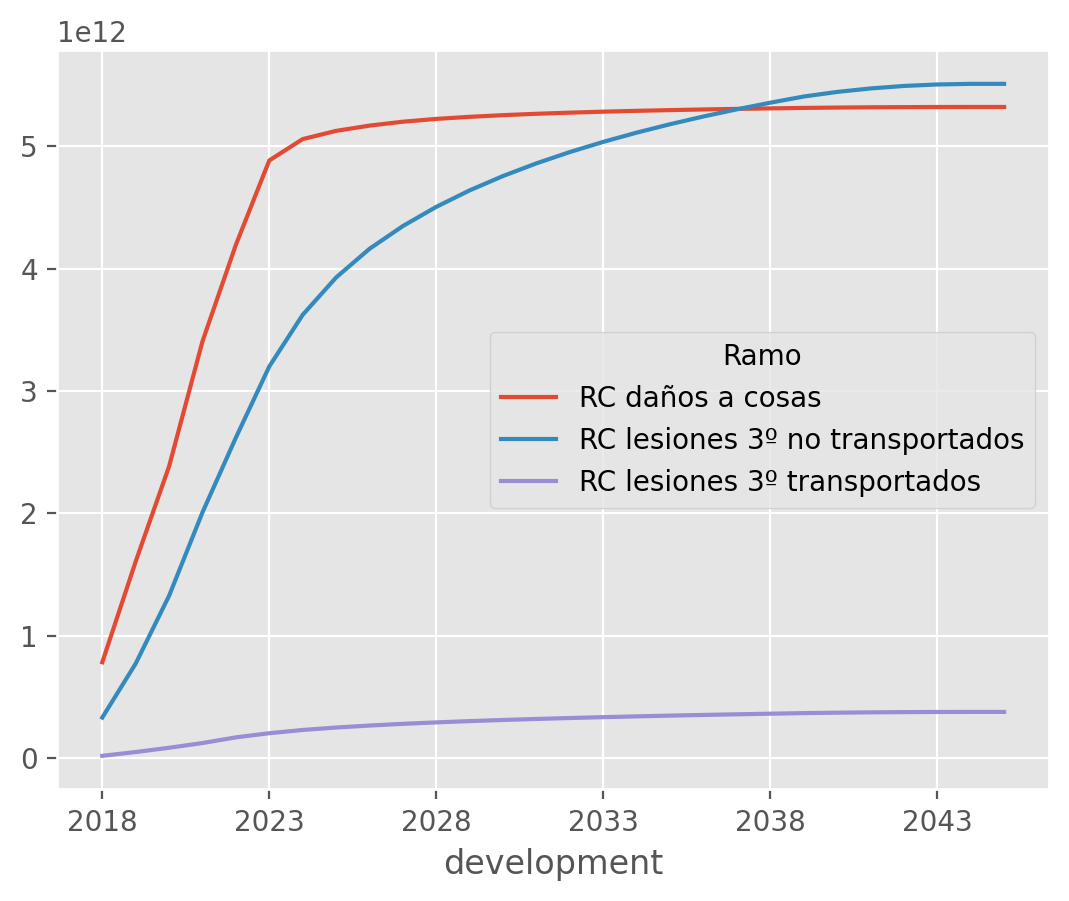

In [220]:
pipe.named_steps.model.full_triangle_.dev_to_val().sum('origin').to_frame().T.plot()

In [ ]:
#RA
pipe = cl.Pipeline(
    steps=[
    ('sample', cl.BootstrapODPSample(random_state=23)),
    ('dev', cl.Development(average='volume')),
    ('tail', cl.TailCurve('inverse_power', extrap_periods= 15, projection_period=15*12)),
    ('model', cl.Chainladder())])

pipe.fit(cl.load_sample('genins'))

In [174]:
resampled_triangles = pipe.named_steps.model.full_triangle_.dev_to_val().cum_to_incr()

In [190]:
resampled_triangles.iloc[0,0]

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2026,2027,2028,2029,2030,2031,2032,2033,2034,2261
2001,"317,494","840,880","764,670","714,777","463,667","246,150","182,655","249,868","399,668","88,348",...,,,,,,,,,,
2002,,"312,345","1,008,973","952,326","769,067","455,146","508,963","286,857","186,862","343,615",...,"28,371",,,,,,,,,
2003,,,"732,420","1,103,018","1,127,952","1,010,419","430,381","340,981","555,780","198,867",...,"39,547","36,703",,,,,,,,
2004,,,,"414,116","1,205,341","744,513","1,157,311","666,609","414,199","518,306",...,"61,509","56,911","52,817",,,,,,,
2005,,,,,"389,217","905,823","753,247","874,199","582,792","453,411",...,"40,070","36,952","34,190","31,731",,,,,,
2006,,,,,,"302,751","447,735","768,306","1,168,326","526,208",...,"47,380","43,537","40,150","37,149","34,476",,,,,
2007,,,,,,,"338,120","816,919","1,114,455","1,125,887",...,"46,099","42,194","38,772","35,756","33,083","30,703",,,,
2008,,,,,,,,"644,384","1,098,245","1,093,321",...,"74,266","67,684","61,951","56,926","52,498","48,573","45,079",,,
2009,,,,,,,,,"549,907","855,027",...,"78,794","71,472","65,138","59,621","54,785","50,523","46,746","43,384",,
2010,,,,,,,,,,"329,157",...,"51,540","46,506","42,185","38,446","35,190","32,336","29,820","27,591","25,606",
